# TODO
1. wyznaczanie pojedynczych puzzli
2. ponumerowanie puzzli
3. ~~wyznaczanie krawędzi~~ - Bartosz
4. ~~wyznaczanie narożników~~ - Bartosz
5. wykorzystanie narożników do podziału krawędzi na 4 boki
6. szukanie patternów/dopasowywanie krawędzi i/lub kolorów

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

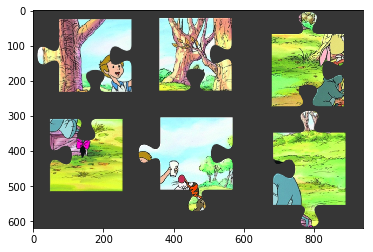

In [2]:
def draw(img):
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))

img = cv2.imread(os.path.join('img', 'puchatek_puzzle_1.png'))
img2 = cv2.imread(os.path.join('img', 'puchatek_puzzle_2.png'))

draw(img)

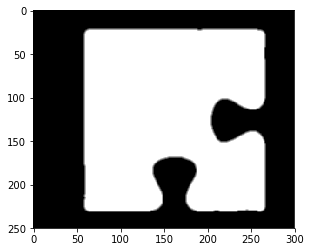

In [206]:
puzz = img[0:250, 300:600]
loc = cv2.cvtColor(puzz, cv2.COLOR_BGR2GRAY)
loc = cv2.medianBlur(loc, ksize=3)
loc = cv2.threshold(loc, 60, 255, cv2.THRESH_BINARY)[1]
loc = cv2.dilate(loc, (5,5))
loc = cv2.medianBlur(loc, ksize=9)
loc = cv2.blur(loc, ksize=(3, 3))

draw(loc)

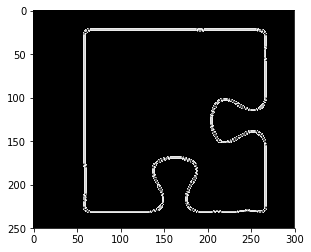

In [207]:
dst = cv2.cornerHarris(np.float32(loc),2,3,0.04)
dst = cv2.dilate(dst,None)
draw(np.uint8(dst))

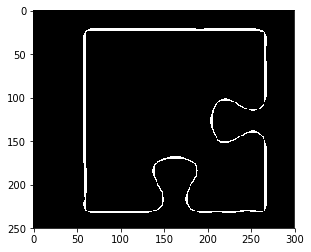

In [276]:
l = np.zeros((dst.shape[0], dst.shape[1]), dtype=np.uint8)

l[dst<0.03*np.min(dst)]=[255]
l[dst>0.03*np.max(dst)]=[255]

draw(l)

In [209]:
lines = cv2.HoughLines(np.uint8(l), 0.1, np.pi/180, 100)

In [210]:
li = []
for el in lines:
    li.append(el[0])

wyn = [[li[0]]]    

res = [li[0]]

for i in range(1, len(li)):
    flag = False
    for k in range(len(res)):
        if (res[k][0]-5 < li[i][0] and li[i][0] < res[k][0]+5) and (res[k][1]-5 < li[i][1] and li[i][1] < res[k][1]+5):
            wyn[k].append(li[i])
            flag = True
    if not flag:
        wyn.append([li[i]])
        res.append(li[i])

moments = []
        
for el in wyn:
    a, b, c = 0, 0, 0
    for e in el:
        a += e[0]
        b += e[1]
        c += 1
    moments.append([a/c, b/c])
    
moments

[[58.95000076293945, 0.0],
 [21.950000762939453, 1.5707963705062866],
 [266.95001220703125, 0.0],
 [230.4499969482422, 1.5707963705062866]]

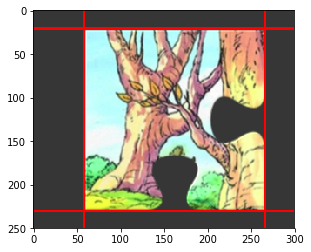

In [211]:
aaaa = puzz.copy()
points = []

for el in moments:
    rho,theta = el[0], el[1]
    a = np.cos(theta)
    b = np.sin(theta)
    
    x0 = a*rho
    y0 = b*rho
    
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    
    points.append([[x1,y1],[x2,y2]])
    
    cv2.line(aaaa, (x1, y1), (x2,y2), (0,0,255), 2)
    
draw(aaaa)

In [302]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1]) #Typo was here

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        return None

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return y, x

In [303]:
corners = set()
for i in range(len(points)):
    for k in range(len(points)):
        lx = line_intersection(points[i], points[k])
        if lx is not None:
            corners.add(lx)
            
corners = np.array(list(corners), dtype=np.int32)
corners = sorted(corners, key=lambda x: (x[0], x[1]), reverse=False)
corners

[array([21, 58]), array([ 21, 266]), array([230,  58]), array([230, 266])]

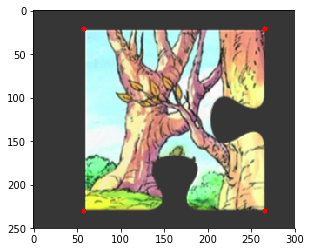

In [304]:
aaaa = puzz.copy()
for el in corners:
    cv2.circle(aaaa, (el[1], el[0]), 3, (0,0,255), -1)
draw(aaaa)

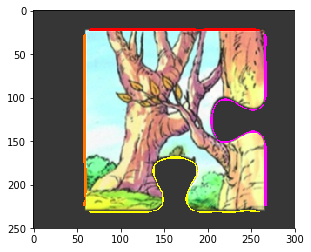

In [322]:
lu = corners[0]
pu = corners[1]
ld = corners[2]
pd = corners[3]

cx, cy = np.int32(line_intersection([lu,pd],[pu,ld]))

aaaa = puzz.copy()

up = []
down = []
left = []
right = []

padl, padr, padu, padd = 0, 0, 0, 0 

for i in range(0, cy):
    if l[0, cx] != l[i, cx]:
        padu = i
        break

for i in range(l.shape[0]-1, cy, -1):
    if l[l.shape[0]-1, cx] != l[i, cx]:
        padd = i
        break
        
for i in range(0, cx):
    if l[cy, 0] != l[cy, i]:
        padl = i
        break
        
for i in range(l.shape[1]-1, cx, -1):
    if l[cy, l.shape[1]-1] != l[cy, i]:
        padr = i
        break
        
for i in range(l.shape[0]):
    for k in range(l.shape[1]):
        if l[i,k] != 0:
            if k > lu[1]+5 and k < pu[1]-5 and i <= padu+5:
                aaaa[i,k]=[0,0,255]
                up.append([i,k])
            if k > lu[1]+5 and k < pu[1]-5 and i >= padd-5:
                aaaa[i,k]=[0,255,255]
                down.append([i,k])
            if i > lu[0]+5 and i < ld[0]-5 and k <= padl+5:
                aaaa[i,k]=[0,120,255]
                left.append([i,k])
            if i > lu[0]+5 and i < ld[0]-5 and k >= padr-5:
                aaaa[i,k]=[255,0,255]
                right.append([i,k])
            
draw(aaaa)

In [323]:
def check_slides(up, down, left, right):
    if np.std(np.array(up)[:,0]) < 5.0:
        print('góra')
    if np.std(np.array(down)[:,0]) < 5.0:
        print('dół')
    if np.std(np.array(left)[:,1]) < 5.0:
        print('lewo')
    if np.std(np.array(right)[:,1]) < 5.0:
        print('prawo')

check_slides(up, down, left, right)

góra
lewo
